<a href="https://colab.research.google.com/github/chiragtyagi2003/idex/blob/main/trained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install patchify


Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install segmentation_models

     ---------------------------------------- 0.0/50.7 kB ? eta -:--:--
     ------------------------------ ------- 41.0/50.7 kB 991.0 kB/s eta 0:00:01
     -------------------------------------- 50.7/50.7 kB 860.9 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/38/d2/3e8c13ffc37ca5ebc6f382b242b44acb43eb489042e1728407ac3904e72f/opencv_python-4.8.1.78-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.1 MB 991.0 kB/s eta 0:00:39
   ---------------------------------------- 0.0/38.1 MB 991.0 kB/s eta 0:00:39
   ---------------------------------------- 0.1/38.1 MB 573.4 kB/s eta 0:01:07
   ---------------------------------------- 0.1/38.1 MB 656.4 kB/s eta 0:00:58
   ---------------------------------------- 0.1/38.1 MB 711.9 kB/s eta 0:00:54
   ---------------------------------------- 0.2/38.1 MB 731.4 kB/s eta 0:00:52
   ---------------------------------------- 0.3/38.1 MB 862.0 kB/s eta 0:00:44
   ---------------------------------------- 0.3/38.1 MB 941.3 kB/s eta 0:00:41
   ---------------------------------------- 0.5/38.1 MB 1.1 MB/s eta 0:00:34


In [ ]:
pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     --------------------------- ---------- 41.0/5

In [ ]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()



Segmentation Models: using `keras` framework.


In [ ]:
from distutils.sysconfig import get_python_lib
print(get_python_lib())

c:\Users\ASUS\anaconda3\Lib\site-packages


In [ ]:
from google.colab import drive

# mount the drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# CHANGE THE PATH OF DATASET
root_dir = "C:\\Users\\ASUS\\Downloads\\archive (9)\\data"


In [ ]:
patch_size = 256



In [ ]:
# read images from respective "images" dir
# crop all images to multiple of 256

image_dataset = []
mask_dataset = []
for path, subdirs, files in os.walk(root_dir):
  # print(path)

  # obtain dir name from the path by extracting last arg
  dir_name = path.split(os.path.sep)[-1]


  if dir_name == "images":
        images = sorted([image_name for image_name in files if image_name.endswith(".jpg")])  # WE ARE SORTING HERE SO THEY LINED WITH THIER CORRESPONDING MASKS WHILE PATCHING
        for image_name in images:
            image = cv2.imread(os.path.join(path, image_name), 1)
            SIZE_X = (image.shape[1] // patch_size) * patch_size
            SIZE_Y = (image.shape[0] // patch_size) * patch_size
            image = Image.fromarray(image)
            image = image.crop((0, 0, SIZE_X, SIZE_Y))
            image = np.array(image)

            print("Now patchifying image:", os.path.join(path, image_name))
            patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    single_patch_img = patches_img[i, j, :, :]
                    single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                    # #single_patch_img = (single_patch_img.astype('float32')) / 255.
                    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.
                    image_dataset.append(single_patch_img)


  elif dir_name == "masks":
        masks = sorted([mask_name for mask_name in files if mask_name.endswith(".png")])   # WE ARE SORTING THEM SO THEY ARE LINED WITH THEIR CORRESPONDING IMAGES WHILE PATCHING
        for mask_name in masks:
            mask = cv2.imread(os.path.join(path, mask_name), 1)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            SIZE_X = (mask.shape[1] // patch_size) * patch_size
            SIZE_Y = (mask.shape[0] // patch_size) * patch_size
            mask = Image.fromarray(mask)
            mask = mask.crop((0, 0, SIZE_X, SIZE_Y))
            mask = np.array(mask)

            print("Now patchifying mask:", os.path.join(path, mask_name))
            patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                    single_patch_mask = patches_mask[i, j, :, :]
                    single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.
                    mask_dataset.append(single_patch_mask)



Now patchifying image: C:\Users\ASUS\Downloads\archive (9)\data\Tile 1\images\image_part_001.jpg
Now patchifying image: C:\Users\ASUS\Downloads\archive (9)\data\Tile 1\images\image_part_002.jpg
Now patchifying image: C:\Users\ASUS\Downloads\archive (9)\data\Tile 1\images\image_part_003.jpg
Now patchifying image: C:\Users\ASUS\Downloads\archive (9)\data\Tile 1\images\image_part_004.jpg
Now patchifying image: C:\Users\ASUS\Downloads\archive (9)\data\Tile 1\images\image_part_005.jpg
Now patchifying image: C:\Users\ASUS\Downloads\archive (9)\data\Tile 1\images\image_part_006.jpg
Now patchifying image: C:\Users\ASUS\Downloads\archive (9)\data\Tile 1\images\image_part_007.jpg
Now patchifying image: C:\Users\ASUS\Downloads\archive (9)\data\Tile 1\images\image_part_008.jpg
Now patchifying image: C:\Users\ASUS\Downloads\archive (9)\data\Tile 1\images\image_part_009.jpg
Now patchifying mask: C:\Users\ASUS\Downloads\archive (9)\data\Tile 1\masks\image_part_001.png
Now patchifying mask: C:\Users\A

In [ ]:
# print(image_dataset)
print(len(image_dataset))

1305


In [ ]:
print(len(mask_dataset))

1305


In [ ]:
# print(mask_dataset)

print(len(mask_dataset))

1305


In [ ]:

image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)


In [ ]:
print(image_dataset[0])

[[[0.78823529 0.76470588 0.74509804]
  [0.88235294 0.85882353 0.83921569]
  [0.94509804 0.90980392 0.89411765]
  ...
  [0.89411765 0.85882353 0.82352941]
  [0.85882353 0.83137255 0.79607843]
  [0.87843137 0.85098039 0.81568627]]

 [[0.88627451 0.8627451  0.84313725]
  [0.99607843 0.97254902 0.95294118]
  [1.         1.         0.98431373]
  ...
  [0.93333333 0.89803922 0.8627451 ]
  [0.92941176 0.90196078 0.86666667]
  [0.95294118 0.91764706 0.88235294]]

 [[0.97254902 0.94509804 0.93333333]
  [1.         0.98823529 0.97647059]
  [1.         1.         0.98431373]
  ...
  [0.93333333 0.89411765 0.86666667]
  [0.92156863 0.89411765 0.85882353]
  [0.90196078 0.86666667 0.83137255]]

 ...

 [[0.88235294 0.8627451  0.86666667]
  [0.81960784 0.80392157 0.8       ]
  [0.7372549  0.73333333 0.71764706]
  ...
  [0.7254902  0.68235294 0.72156863]
  [0.85490196 0.82352941 0.86666667]
  [0.67843137 0.65882353 0.69411765]]

 [[0.76862745 0.75294118 0.74901961]
  [0.79215686 0.77647059 0.77254902]


## Take Care of Labels

112


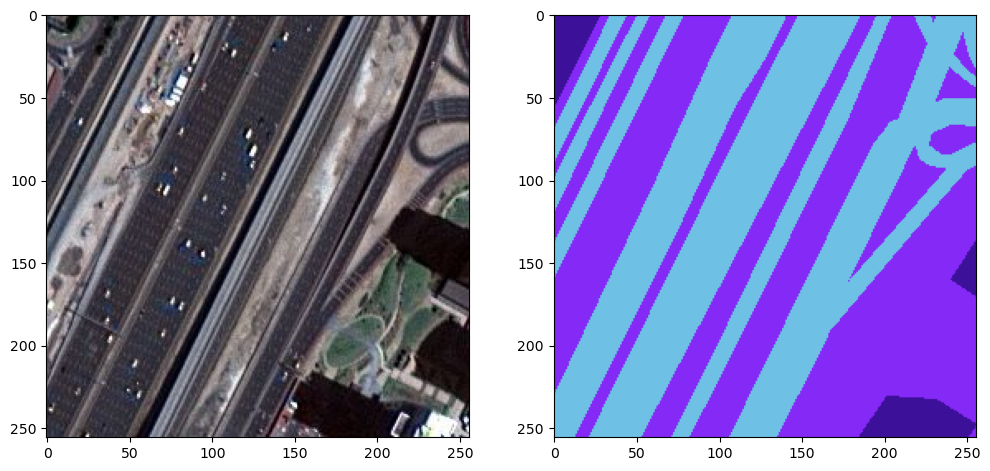

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
print(image_number)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()



## TAKING CARE OF LABELS

In [ ]:
# Building: #3C1098
# Land (unpaved area): #8429F6
# Road: #6EC1E4
# Vegetation: #FEDD3A
# Water: #E2A929
# Unlabeled: #9B9B9B

In [ ]:
"""
RGB to HEX: (Hexadecimel --> base 16)
This number divided by sixteen (integer division; ignoring any remainder) gives
the first hexadecimal digit (between 0 and F, where the letters A to F represent
the numbers 10 to 15). The remainder gives the second hexadecimal digit.
0-9 --> 0-9
10-15 --> A-F

Example: RGB --> R=201, G=, B=

R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)

Calculating RGB from HEX: #3C1098
3C = 3*16 + 12 = 60
10 = 1*16 + 0 = 16
98 = 9*16 + 8 = 152

"""

'\nRGB to HEX: (Hexadecimel --> base 16)\nThis number divided by sixteen (integer division; ignoring any remainder) gives\nthe first hexadecimal digit (between 0 and F, where the letters A to F represent\nthe numbers 10 to 15). The remainder gives the second hexadecimal digit.\n0-9 --> 0-9\n10-15 --> A-F\n\nExample: RGB --> R=201, G=, B=\n\nR = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)\n\nCalculating RGB from HEX: #3C1098\n3C = 3*16 + 12 = 60\n10 = 1*16 + 0 = 16\n98 = 9*16 + 8 = 152\n\n'

In [ ]:
#Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60.
print(a)


60


In [ ]:
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155


In [ ]:
print(Water)

[226 169  41]


In [ ]:
# NOW WE WILL INTEGER CODE THE LABELS.. FROM 0 TO 6
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5

    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels

    return label_seg


In [ ]:
# NOW USING THE ABOVE DEFINED FUCNTION WE WILL CONVERT
# THE RGB VALUES IN MASKS TO INTEGER LABELS
# THE 4TH ELEMENT -> 1 IN SHAPE SHOWS THAT THE CLASSES
# ARE REPRESENTED AS INTEGER VARIABLES
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [ ]:
print(labels.shape)

(1305, 256, 256, 1)


Unique labels in label dataset are:  [0 1 2 3 4 5]


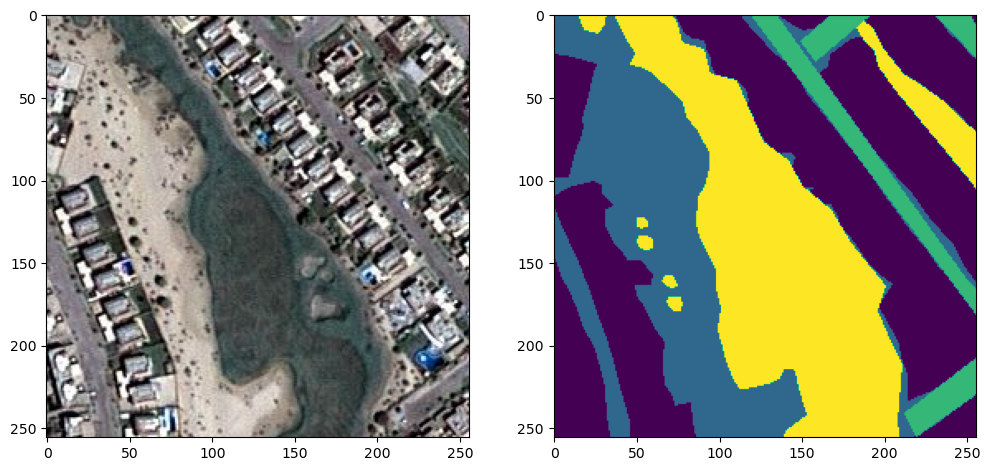

In [ ]:
# SOME SANITY CHECKS
print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()


In [ ]:
#NOW LETS CONVERT THE INTEGER LABELS TO ONE HOT ENOCDED

n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

In [ ]:
# THE 6 HERE REPERESENTS 6 CLASSES, REPRESETENTED IN BINARY
print(labels_cat.shape)

(1305, 256, 256, 6)


### TRAINING PART

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [ ]:
# WE ADD A DROPOUT LAYER TO THE SIMPLE UNET MODEL ARCH
# AND DEFINE JACARD COEFF
# https://youtu.be/jvZm8REF2KY
"""
Standard Unet
Model not compiled here, instead will be done externally to make it
easy to test various loss functions and optimizers.
"""


from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)



################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model


In [ ]:
 # HERE ALL CLASSES ARE NOT BALANCED
 # SO FOR LOSS FUNCTION WE CAN EXPERIMENT
 # WITH DEFINING WEIGHTS, WE CAN USE DICE LOSS + FOCAL_LOSS TO MAKE UP A TOTAL LOSS
 # INTITIALLY THE WEIGHTS EITHER CAN BE COMPUTED OR CAN BE PROVIDED AS LIST WITH EQUAL WIEIGHTS
 # EACH WEIGHT CAN BE HERE 1/NUM OF CLASSES HERE WE HAVE 6 SO 1/6 = 0.1666

In [ ]:
#Parameters for model
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss
# from sklearn.utils.class_weight import compute_class_weight

# weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')),
#                               np.ravel(labels,order='C'))
# print(weights)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


metrics=['accuracy', jacard_coef]

# GET THE MODEL
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)


In [ ]:
model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()





Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                           

In [ ]:
print(model.input_shape)

(None, 256, 256, 3)


In [ ]:
print(len(X_train))

1044


In [ ]:
# ONE MORE TIME WITH FEELING
history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/50
66/66 [==============================] - 255s 4s/step - loss: 0.9911 - accuracy: 0.5798 - jacard_coef: 0.2882 - val_loss: 0.9789 - val_accuracy: 0.6463 - val_jacard_coef: 0.3088
Epoch 2/50
66/66 [==============================] - 233s 4s/step - loss: 0.9688 - accuracy: 0.6606 - jacard_coef: 0.3983 - val_loss: 0.9732 - val_accuracy: 0.6815 - val_jacard_coef: 0.3983
Epoch 3/50
66/66 [==============================] - 229s 3s/step - loss: 0.9561 - accuracy: 0.7219 - jacard_coef: 0.4605 - val_loss: 0.9666 - val_accuracy: 0.6944 - val_jacard_coef: 0.4517
Epoch 4/50
66/66 [==============================] - 231s 4s/step - loss: 0.9461 - accuracy: 0.7470 - jacard_coef: 0.5088 - val_loss: 0.9599 - val_accuracy: 0.7144 - val_jacard_coef: 0.4840
Epoch 5/50
66/66 [==============================] - 232s 4s/step - loss: 0.9386 - accuracy: 0.7719 - jacard_coef: 0.5519 - val_loss: 0.9537 - val_accuracy: 0.7371 - val_jacard_coef: 0.5145
Epoch 6/50
66/66 [==============================] - 205

In [ ]:
model.save('D:\\chirag\\models\\aerial_image_segmentation_50epochs.hdf5')

c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('D:\\chirag\\models\\unet_aerial_image_segmentation_50epochs.keras')

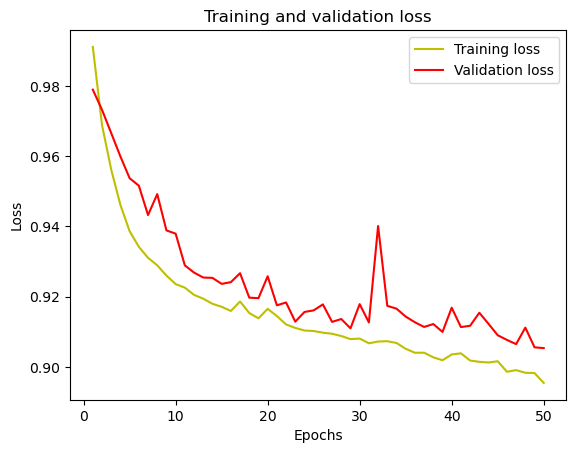

In [ ]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
